# Building a simple neural network in PyTorch

Open this notebook in colab: https://colab.research.google.com/github/simw/neural-network-notebooks/blob/main/Simple%20Deep%20Learning%20Examples/Simple%20Functional%20PyTorch.ipynb

In this notebook, we will build a simple fully-connected feed-forward network using a ReLU activation, and use it to classify the FashionMNIST dataset. This is a similar use case to the torch quick start at (https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html).

We will explicitly create the parameters and calculations, rather than using torch's nn module's functionality, in order to demonstrate the calculations. In a separate notebook, we'll use the built-in functionality, which will shorten the code (and likely improve performance, reliability etc).

### Globals

To begin, we import math and matplotlib for display / feedback purporses, and torch.

We also create a global variable for the torch device. torch can run its calculations on the CPU, but for better performance it can run on NVIDIA's CUDA (ie an NVIDIA GPU) or on Apple's Metal (on a Mac), if available.

But to do this, we need to tell torch where to put its tensors - either by creating them directly on the relevant device (eg by setting 'device=' when creating them), or by moving them there after creation (by doing eg tensor.to(device)).

Below, whenever we create a torch tensor, we'll set device=TORCH_DEVICE. Alternatively, if we don't have control over the creation of the tensor (eg in a data loader), we can do tensor.to(TORCH_DEVICE) to move the data onto the device.

In notebooks, people don't always follow consistent naming conventions (nor will this one), but to make it clear in functions that TORCH_DEVICE is a global variable, we'll capitalize it.

In [1]:
import math

import matplotlib.pyplot as plt
import torch

TORCH_DEVICE = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)

### Loading Data

A key part of training a neural network is loading the training data from storage onto the device where the processing will take place (eg the GPU). Some desired features of this process are:

- Being able to split the dataset into training, testing and validation sets.
- Being able to either randomly sample from the entire dataset or to iterate over it deterministicly.
- Loading the data into the framework's data structure - ie a torch.tensor - where it is either already on the target device (eg GPU) or can easily be moved there (by using tensor.to(device)).
- Loading the data fast enough to keep up with the training, but without using too much memory (as the network may want to use that memory). An iterator that lazily loads the data is a suitable structure.
- Loading the data in batches. For training the network, we will want to process the data in batches, rather than one-by-one. This is for efficiency (GPUs are very good at parallel processing) and for the stochastic gradient descent, where the loss is evaluated as an average across a batch.

As with most data science projects, acquiring the cleaning data is often a bigger job than creating the model. Each type of data - text data for NLP, image data etc - will have its own details to consider.

Why focus on the data loading now, rather than after constructing the network? Because the structure of the network may depend on the structure of the data. For example, image data will naturally have a 2-dimensional structure, which the network can choose to use (eg in convolutional neural networks) or to ignore (eg by flattening the data immediately and using a fully-connected feed-forward network). Either way, the first (and possibly subsequent) layer(s) of the network will need to deal with the 2D structure.

To keep this notebook clean, the (minimal amount of) data loading code has been kept in a separate python module.

In [2]:
from src.dataloader import get_dataloader

training_dataloader = get_dataloader(batch_size=64, train=True)
testing_dataloader = get_dataloader(batch_size=64, train=False)
for inputs, targets in training_dataloader:
    print(f"Shape of inputs (aka 'X') is {inputs.shape}")
    print(f"Shape of targets (aka 'y') is {targets.shape}")
    break

Shape of inputs (aka 'X') is torch.Size([64, 1, 28, 28])
Shape of targets (aka 'y') is torch.Size([64])


Hence, the data has shapes:

- Input shape is (batch_size = 64, channels = 1, height = 28, width = 28)
- Output shape is (batch_size = 64)

This image data has only 1 channel (ie color), as it's a grayscale image. A color image would have more channels.

### Building the network

Here, as mentioned above, we're going to build the network from scratch, without using torch's nn module, in order to demonstrate the operation of the network. Later, we'll re-implement using torch's built-in functionality - which will provide a better, faster and more reliable implementation.

We're going to need four different operations to build this neural network:

- Flattening. Each input image is in shape (channels, height, width). In this example, we won't use the 2 dimensional structure of the image, and will just flatten it into a (height x width, 1) vector.
- Linear
- Activation function - ReLU
- Soft max

#### Flattening

As we create functions for each layer, we're also going to write some code to demonstrate and test that layer. This is similar to (but less rigorous than) writing tests for python modules. A significant challenge when using torch / matrix code is keeping track of the dimensions / shapes, and knowing when the framework broadcasts across dimensions.

In [3]:
def flatten_layer(inputs):
    """
    inputs: shape (batch_size, ...)
    ie the inputs can have any number of dimensions >= 2, and the
    output will flatten this to (batch_size, ?)
    """
    batch_size = inputs.shape[0]
    return inputs.view((batch_size, -1))

In [4]:
# Code to test / demonstrate the flatten_layer
sample_batch_size = 24
sample_inputs = torch.rand((sample_batch_size, 5, 12, 28), device=TORCH_DEVICE)
result = flatten_layer(sample_inputs)

print(f"{sample_inputs.shape=}, {result.shape=}")
expected_shape = torch.Size([sample_batch_size, math.prod(sample_inputs.shape[1:])])
assert result.shape == expected_shape
assert result[0, :28].equal(sample_inputs[0, 0, 0, :])

sample_inputs.shape=torch.Size([24, 5, 12, 28]), result.shape=torch.Size([24, 1680])


#### Linear layer

As well as defining linear_layer, we also create a function to initialize the parameters before the training of the neural network.

Here, we initialize consistent with torch.nn.Linear, with a uniform distribution.

In [5]:
def linear_layer(inputs: torch.Tensor, params: tuple[torch.Tensor, torch.Tensor]):
    """
    inputs: dimensions (*, dim_in)
    params: tuple ((dim_in, dim_out), (1, dim_out))
    outputs: dimensions (*, dim_out)

    ie the inputs can have any shape as long as the last dimension
    is dim_in. Then the output will be the same shape, finishing with dim_out.

    In a simple network, the input will be (batch_size, dim_in), giving
    output (batch_size, dim_out).
    """
    w, b = params
    return inputs @ w + b
    

def random_linear_params(dim_in: int, dim_out: int, generator, scale: float | None = None):
    """
    Generate random parameters from a uniform distribution for a linear_layer
    """
    if scale is None:
        scale = dim_in ** -0.5
    with torch.no_grad():
        w = -scale + 2 * scale * torch.rand(
            size=(dim_in, dim_out),
            generator=generator,
            device=TORCH_DEVICE
        )
        b = -scale + 2 * scale * torch.rand(
            size=(1, dim_out),
            generator=generator,
            device=TORCH_DEVICE
        )
    w.requires_grad_(True)
    b.requires_grad_(True)
    return w, b

In [6]:
# Code to test / demonstrate the linear_layer
sample_batch_size = 100
dim_in = 3
dim_out = 4
sample_rand_gen = torch.Generator(device=TORCH_DEVICE).manual_seed(12345678)
sample_inputs = torch.normal(mean=0, std=1, size=(sample_batch_size, 2, 3, dim_in), generator=sample_rand_gen, device=TORCH_DEVICE)
sample_params = random_linear_params(dim_in, dim_out, sample_rand_gen)
result = linear_layer(sample_inputs, sample_params)


assert result.shape == (sample_batch_size, 2, 3, dim_out)
print(f"{sample_inputs.shape=}")
print(f"Sample params shapes = {[p.shape for p in sample_params]}")
print(f"{result.shape=}")

sample_inputs.shape=torch.Size([100, 2, 3, 3])
Sample params shapes = [torch.Size([3, 4]), torch.Size([1, 4])]
result.shape=torch.Size([100, 2, 3, 4])


#### Soft max

We leave the softmax layer as logs, as opposed to exponentiating the result.

In [7]:
def log_softmax_layer(inputs):
    """
    inputs: shape (*, dim_in)
    returns: shape (*, dim_in)

    For a simple example, inputs = (batch_size, dim_in)
    and returns = (batch_size, dim_in)
    """
    logsumexp = torch.log(torch.sum(torch.exp(inputs), dim=-1, keepdim=True))
    return inputs - logsumexp

In [8]:
sample_batch_size = 100
dim_in = 23
sample_inputs = torch.normal(mean=0, std=1, size=(sample_batch_size, dim_in), generator=sample_rand_gen, device=TORCH_DEVICE)
result = log_softmax_layer(sample_inputs)
assert result.shape == sample_inputs.shape
sums = torch.sum(torch.exp(result), dim=1)
assert sums.shape == (sample_batch_size, )
assert sums.isclose(torch.tensor(1.)).all()

#### Combining the layers

Combining the above layers gives the full model

In [9]:
def predict(params, inputs):
    x = inputs
    x = flatten_layer(x)
    x = linear_layer(x, params["linear_1"])
    x = torch.relu(x)
    x = linear_layer(x, params["linear_2"])
    x = torch.relu(x)
    x = linear_layer(x, params["linear_3"])
    x = log_softmax_layer(x)
    return x

In [10]:
# Testing / demonstrating the model
sample_batch_size = 100
image_shape = (1, 28, 28)
dim_in = math.prod(image_shape)
dim_hidden = 24
dim_out = 25

sample_rand_gen = torch.Generator(device=TORCH_DEVICE).manual_seed(12345678)
sample_params = {
    "linear_1": random_linear_params(dim_in, dim_hidden, sample_rand_gen),
    "linear_2": random_linear_params(dim_hidden, dim_hidden, sample_rand_gen),
    "linear_3": random_linear_params(dim_hidden, dim_out, sample_rand_gen),
}
sample_inputs = torch.normal(mean=0, std=1, size=(sample_batch_size, image_shape[0], image_shape[1], image_shape[2]), device=TORCH_DEVICE)
result = predict(sample_params, sample_inputs)
print(f"{sample_inputs.shape=}, {result.shape=}")
assert result.shape == (sample_batch_size, dim_out)

sample_inputs.shape=torch.Size([100, 1, 28, 28]), result.shape=torch.Size([100, 25])


Now we have 2 functions:

- predict(params, inputs)
- random_linear_params(dim_in, dim_out, generator, scale)

### Training the network

We now have:
- The structure of the model, ie a function to map inputs to predictions, but with randomly initialized values.
- Labelled data, with inputs and target values

We now want to train the model, so that the model will give good predictions for the classes.

To do that, we need to define a function to say how 'good' the model is, ie the loss function. As we evaluate the model on the data, we'll move the parameters in the direction of improving the model by applying stochastic gradient descent.

Here, we'll apply simple SGD. There are more advanced algorithms, but all / most are an adjustment on top of stochastic gradient descent: rolling down the gradient, but adjusted either for momentum or for reducing the noise in each (stochastic) evaluation of the gradient.

In [11]:
def loss_fn(logits, targets):
    """
    logits: shape (batch_size, dim_out)
    targets: shape (batch_size, 1), values in range(dim_out)

    ie logits is encoding the probability of each category.
    """
    batch_size = logits.shape[0]
    return -torch.mean(logits[torch.arange(batch_size), targets])

In [12]:
# Testing / demonstrating the model
sample_batch_size = 99
image_shape = (1, 28, 28)
dim_in = math.prod(image_shape)
dim_hidden = 24
dim_out = 25

sample_rand_gen = torch.Generator(device=TORCH_DEVICE).manual_seed(12345678)
sample_params = {
    "linear_1": random_linear_params(dim_in, dim_hidden, sample_rand_gen),
    "linear_2": random_linear_params(dim_hidden, dim_hidden, sample_rand_gen),
    "linear_3": random_linear_params(dim_hidden, dim_out, sample_rand_gen),
}
sample_inputs = torch.normal(mean=0, std=1, size=(sample_batch_size, image_shape[0], image_shape[1], image_shape[2]), device=TORCH_DEVICE)
sample_targets = torch.randint(dim_out, size=(sample_batch_size, ), device=TORCH_DEVICE)
result = predict(sample_params, sample_inputs)
print(result.shape)
this_loss = loss_fn(result, sample_targets)
assert this_loss.shape == torch.Size([])

torch.Size([99, 25])


In [13]:
def test(dataloader, params, predictor, loss_fn):
    all_targets = []
    all_predictions = []
    all_losses = []
    with torch.no_grad():
        for inputs, targets in testing_dataloader:
            inputs = inputs.to(TORCH_DEVICE)
            predictions = predict(params, inputs)
            loss = loss_fn(predictions, targets)
            all_predictions.append(predictions.argmax(dim=1).cpu())
            all_targets.append(targets)
            all_losses.append(loss)

    all_predictions = torch.cat(all_predictions)
    all_targets = torch.cat(all_targets)

    return all_targets, all_predictions, all_losses

In [14]:
rand_gen = torch.Generator(device=TORCH_DEVICE).manual_seed(12345678)
dim_in = 1 * 28 * 28
dim_hidden = 512
dim_out = 10
params = {
    "linear_1": random_linear_params(dim_in, dim_hidden, rand_gen),
    "linear_2": random_linear_params(dim_hidden, dim_hidden, rand_gen),
    "linear_3": random_linear_params(dim_hidden, dim_out, rand_gen),
}

initial_params = {key: [p.clone() for p in ps] for key, ps in params.items()}

step_size = 1e-3
epochs = 5

for t in range(epochs):
    print(f"Epoch {t + 1}\n-----------------------")
    total_length = len(training_dataloader.dataset)
    count = 0
    for batch, (inputs, targets) in enumerate(training_dataloader):
        inputs = inputs.to(TORCH_DEVICE)
        targets = targets.to(TORCH_DEVICE)
        predictions = predict(params, inputs)
        loss = loss_fn(predictions, targets)

        for ps in params.values():
            for p in ps:
                p.grad = None

        loss.backward()

        for ps in params.values():
            for p in ps:
                p.data += -step_size * p.grad

        count += len(inputs)
        if batch % 100 == 0 or count >= total_length:
            print(f"loss: {loss.item():>7f}  [{count:>5d} / {total_length:>5d}]")
    
    test_targets, test_preds, test_losses = test(testing_dataloader, params, predict, loss_fn)
    correct = (test_preds.eq(test_targets).sum() / len(test_preds)).item()
    losses = torch.tensor(test_losses)
    print(f"Test error: accuracy = {100 * correct:>0.1f}%, average loss = {losses.mean().item():>8f}")

Epoch 1
-----------------------
loss: 2.326455  [   64 / 60000]
loss: 2.307028  [ 6464 / 60000]
loss: 2.292223  [12864 / 60000]
loss: 2.268616  [19264 / 60000]
loss: 2.258258  [25664 / 60000]
loss: 2.227267  [32064 / 60000]
loss: 2.229905  [38464 / 60000]
loss: 2.201060  [44864 / 60000]
loss: 2.199062  [51264 / 60000]
loss: 2.161501  [57664 / 60000]
loss: 2.161937  [60000 / 60000]
Test error: accuracy = 41.2%, average loss = 2.165764
Epoch 2
-----------------------
loss: 2.186427  [   64 / 60000]
loss: 2.177311  [ 6464 / 60000]
loss: 2.120090  [12864 / 60000]
loss: 2.122921  [19264 / 60000]
loss: 2.084919  [25664 / 60000]
loss: 2.013812  [32064 / 60000]
loss: 2.048636  [38464 / 60000]
loss: 1.972935  [44864 / 60000]
loss: 1.976712  [51264 / 60000]
loss: 1.908124  [57664 / 60000]
loss: 1.917644  [60000 / 60000]
Test error: accuracy = 56.5%, average loss = 1.909528
Epoch 3
-----------------------
loss: 1.944704  [   64 / 60000]
loss: 1.918929  [ 6464 / 60000]
loss: 1.801139  [12864 / 600

### Using the network

In [15]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

test_targets, test_preds, test_losses = test(testing_dataloader, params, predict, loss_fn)

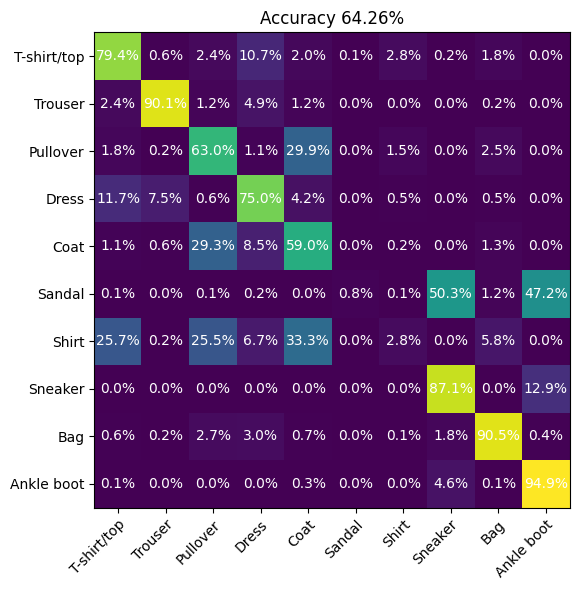

In [16]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(test_targets, test_preds)
confusion = confusion / confusion.sum(axis=1)

accuracy = (test_preds.eq(test_targets).sum() / len(test_preds)).item()

fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(confusion)
ax.set_xticks(torch.arange(len(classes)), labels=classes)
ax.set_yticks(torch.arange(len(classes)), labels=classes)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(classes)):
    for j in range(len(classes)):
        text = ax.text(j, i, f"{confusion[i, j]:.1%}",
                       ha="center", va="center", color="w")

ax.set_title(f"Accuracy {accuracy:.2%}")
fig.tight_layout()

plt.show()

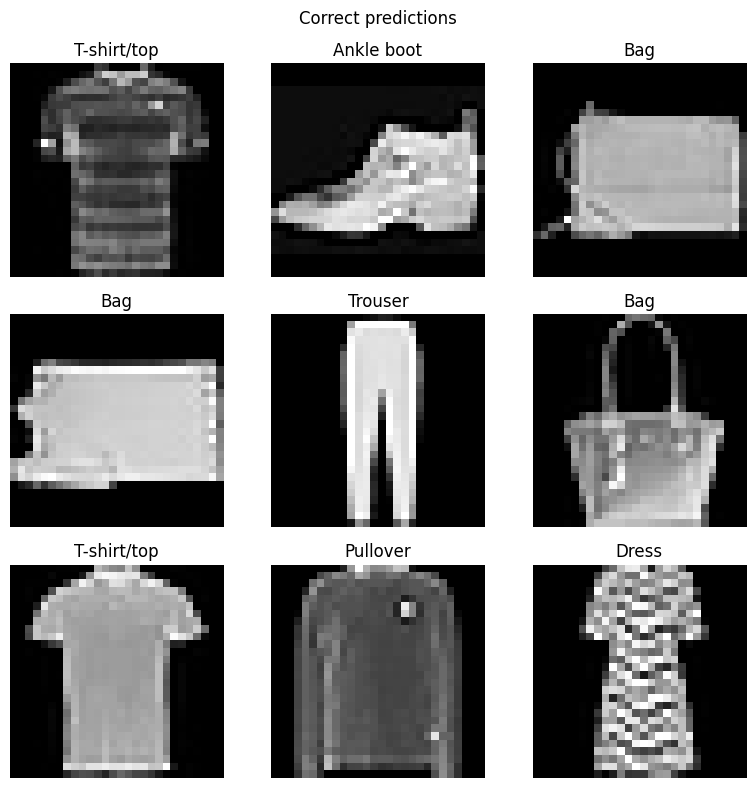

In [17]:
correct = torch.nonzero(test_targets == test_preds)
fig_gen = torch.Generator().manual_seed(12345678)

fig = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(correct), size=(1,), generator=fig_gen).item()
    img, label = testing_dataloader.dataset[correct[sample_idx].item()]
    fig.add_subplot(rows, cols, i)
    plt.title(classes[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
fig.suptitle("Correct predictions")
fig.tight_layout()
plt.show()

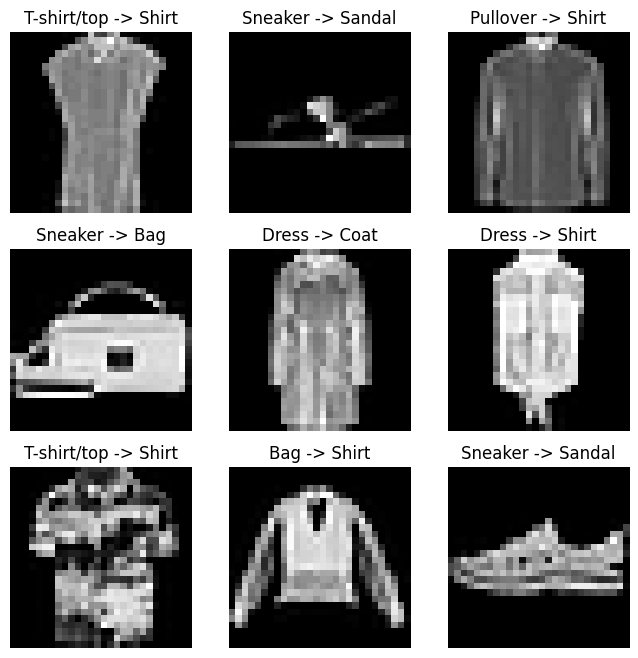

In [18]:
incorrect = torch.nonzero(test_targets != test_preds)
fig_gen = torch.Generator().manual_seed(12345678)

fig = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(incorrect), size=(1,), generator=fig_gen).item()
    img, label = testing_dataloader.dataset[incorrect[sample_idx].item()]
    predicted = classes[test_preds[incorrect[sample_idx]].item()]
    fig.add_subplot(rows, cols, i)
    plt.title(f"{predicted} -> {classes[label]}")
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()